In [1]:
import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from utils import print_full
from scipy.ndimage import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from utils import *
from visualize import *
set_plot_params()
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


from model_neuroformer import GPT, GPTConfig, neuralGPTConfig, Decoder
from trainer import Trainer, TrainerConfig


import json
# for i in {1..10}; do python3 -m gather_atts.py; done


In [2]:
from neuroformer.prepare_data import load_LRN

df, stimulus = load_LRN()


In [3]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)


In [4]:
from utils import set_seed
n_seed = 25
set_seed(n_seed)


In [5]:
# load config files

import yaml

base_path = "./models/tensorboard/LRN/final/window:0.5_prev:19.5/sparse_f:None_id:None/w:0.5_wp:19.5"

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)


In [6]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
w_mult = 3
frame_window = dconf.frame_window
window = dconf.window
window_prev = dconf.window_prev
dt = dconf.dt
dt_frames = dconf.dt_frames
# p_window = window / (window + window_prev)
# intervals = np.load(os.path.join(base_path, "intervals.npy"))
intervals = None


from SpikeVidUtils import make_intervals

df['real_interval'] = make_intervals(df, dt)
df['Interval'] = make_intervals(df, window)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']


In [7]:
int_trials = df.groupby(['Interval', 'Trial']).size()
print(int_trials.mean())
# df.groupby(['Interval', 'Trial']).agg(['nunique'])model_path
# var_group = 'Interval_2'
# n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
# df.groupby(['Interval_2', 'Trial']).size().mean()



9.68422611538335


In [8]:
from SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_embd = mconf.n_embd
frame_feats = torch.tensor(stimulus, dtype=torch.float32).transpose(1, 0)
frame_block_size = mconf.frame_block_size  # math.ceil(frame_feats.shape[-1] * frame_window)
n_embd_frames = mconf.n_embd_frames

prev_id_block_size = mconf.prev_id_block_size    # math.ceil(frame_block_size * (1 - p_window))
id_block_size = mconf.id_block_size           # math.ceil(frame_block_size * p_window)
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = dconf.frame_memory   # how many frames back does model see

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }

In [9]:
r_split = 0.8
train_trials = sorted(df['Trial'].unique())[:int(len(df['Trial'].unique()) * r_split)]
train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]

In [10]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)


train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=intervals)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                 window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                 pred=False, window_prev=window_prev, frame_window=frame_window,
                                 dt_frames=dt_frames, intervals=intervals)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')


Length: 705418 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150
Length: 177367 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150
train: 58888, test: 14725


In [11]:
# from utils import get_class_weights
# class_weights = get_class_weights(train_dataset, stoi, stoi_dt)


In [12]:
from model_neuroformer_LRN import GPT, GPTConfig
# initialize config class and model (holds hyperparameters)
   
conv_layer = False
model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=False, p_sparse=0.25, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=mconf.n_state_layers, n_state_history_layers=mconf.n_state_history_layers,
                        n_stimulus_layers=mconf.n_stimulus_layers, self_att_layers=mconf.self_att_layers,
                        n_head=mconf.n_head, n_embd=mconf.n_embd, 
                        contrastive=True, clip_emb=1024, clip_temp=0.5,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.35, im_drop=0.35,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        n_embd_frames=n_embd_frames, dataset=None,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'])  # 0.35

for k, v in model_conf.__dict__.items():
    if not hasattr(mconf, k):
        print(f"k: {k}, v: {v}")
        setattr(mconf, k, v)

model = GPT(mconf)

02/22/2023 13:00:44 - INFO - model_neuroformer_LRN -   number of parameters: 2.592484e+07


In [13]:
layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)
max_epochs = 300
batch_size = round((14))
shuffle = True

weighted = True if mconf.class_weights is not None else False
title =  f'window:{window}_prev:{window_prev}_smooth'
model_path = f"""./models/tensorboard/LRN/ignore_index/2_{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

# model_path = "/data5/antonis/neuroformer/models/tensorboard/LRN/channel/window:0.5_prev:19.5_smooth/sparse_f:None_id:None/w:0.5_wp:19.5/6_Cont:True_window:0.5_f_window:20_df:0.1_blocksize:150_conv_False_shuffle:True_batch:12_sparse_(None_None)_blocksz1150_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_197_max0.1_(8, 8, 8)_8_256.pt"
# if os.path.exists(model_path):
#     print(f"Loading model from {model_path}")
#     model.load_state_dict(torch.load(model_path))
# else:
#     print(f"Model not found at {model_path}")
#     raise FileNotFoundError

tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=False, patience=3, warmup_tokens=8e7, 
                    decay_weights=True, weight_decay=0.2, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=True, save_every=1000)

# trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
# trainer.train()

In [14]:
loader = DataLoader(train_dataset, batch_size=32 * 8, shuffle=shuffle, num_workers=4, pin_memory=True)
iterable = iter(loader)

In [15]:
x, y = next(iterable)

In [16]:
"""

RUN SIMULATION

"""

from utils import *
from IPython.utils import io
# top_p=0.25, top_p_t=0.9, temp=2.

model_weights = glob.glob(os.path.join(base_path, '**/**.pt'), recursive=True)
model_weights = sorted(model_weights, key=os.path.getmtime, reverse=True)
assert len(model_weights) > 0, "No model weights found"

if model_path in model_weights:
    load_weights = model_path
else:
    print(f'Loading weights from {os.path.basename(model_weights[0])}')
    load_weights = model_weights[0]

model.load_state_dict(torch.load(load_weights, map_location=torch.device('cpu')))

trials = test_data['Trial'].unique()[:4]

Loading weights from 6_Cont:False_window:0.5_f_window:20_df:0.1_blocksize:150_conv_False_shuffle:True_batch:88_sparse_(None_None)_blocksz1150_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_197_max0.1_(8, 8, 8)_8_256.pt


In [17]:
from utils import predict_raster_recursive_time_auto

results_dict = dict()
df_pred = None
df_true = None

top_p = 0.95
top_p_t = 0.95
temp = 1
temp_t = 1


for trial in trials:    # test_data['Trial'].unique():
    # with io.capture_output() a
    #s captured:
        print(f"Trial: {trial}")
        df_trial = df[df['Trial'] == trial]
        trial_dataset = SpikeTimeVidData2(df_trial,  None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=intervals)
        trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
        results_trial = predict_raster_recursive_time_auto(model, trial_dataset, window, window_prev, stoi, itos_dt, itos=itos, 
                                                           sample=True, top_p=top_p, top_p_t=top_p_t, temp=temp, temp_t=temp_t, 
                                                           frame_end=0, get_dt=True, gpu=False, pred_dt=True)
        # results_trial = predict_raster_hungarian(model, loader, itos_dt, top_p=0.75, temp=1)
        # print(f"MAX ID ---- {sorted(results_trial['ID'].unique()[-10])}")
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])


from analysis import compute_scores
scores = compute_scores(df[df['Trial'].isin(trials)], df_pred)
print(scores)
print(f"pred: {len(df_pred)}, true: {len(df_true)}" )


Trial: 401
Length: 1494 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150


len pred: 1165, len true: 1488: 100%|██████████| 149/149 [03:04<00:00,  1.24s/it]


SOS fouuuund: 0
EOS fouuuund: 149
pred: (1085, 5), true: (1339, 2)
Trial: 402
Length: 1842 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150


len pred: 1705, len true: 1809: 100%|██████████| 150/150 [04:08<00:00,  1.66s/it]


SOS fouuuund: 0
EOS fouuuund: 150
pred: (1640, 5), true: (1659, 2)
Trial: 403
Length: 1905 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150


len pred: 1335, len true: 1924: 100%|██████████| 144/144 [03:23<00:00,  1.42s/it]


SOS fouuuund: 0
EOS fouuuund: 144
pred: (1257, 5), true: (1780, 2)
Trial: 404
Length: 1606 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150


len pred: 1538, len true: 1683: 100%|██████████| 152/152 [04:03<00:00,  1.60s/it]


SOS fouuuund: 0
EOS fouuuund: 152
pred: (1449, 5), true: (1531, 2)
defaultdict(<class 'list'>, {'precision': 0.03986152351038413, 'recall': 0.031936756054323626, 'F1': 0.03209033677735273})
pred: 5431, true: 6309


In [18]:
from SpikeVidUtils import set_intevals
from analysis import get_rates_trial, calc_corr_psth

# df_pred_path = "/data5/antonis/neuroformer/models/tensorboard/LRN/channel/window:0.5_prev:19.5_smooth/sparse_f:None_id:None/w:0.5_wp:19.5/df_pred_window:0.5_prev:19.5_smooth_top_p0.75_top_p0.75_top_p0.75_top_p0.75_.csv"
# df_pred = pd.read_csv(df_pred_path)

df_3 = df[df['Trial'].isin(trials + 2)]
df_1 = df[df['Trial'].isin(trials)]
df_2 = df[df['Trial'].isin(trials + 1)]

df_pred_full = df_pred
df_list = [df_pred_full, df_1, df_2, df_3]

window_pred = 20
min_window = window + window_prev
max_window = df['Interval'].max() # - (window)
df_pred_full = set_intevals(df_pred_full, window, window_prev, max_window, window_pred, min_window)
df_1 = set_intevals(df_1, window, window_prev, max_window, window_pred, min_window)
df_2 = set_intevals(df_2, window, window_prev, max_window, window_pred, min_window)
df_3 = set_intevals(df_3, window, window_prev, max_window, window_pred, min_window)

window_pred = window if window_pred is None else window_pred
intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))

# labels = sorted(set(df_pred_full['Interval'].unique()))
rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)
top_corr_real = calc_corr_psth(rates_1, rates_2)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3)

id_pred: 739, id_true_1: 824, id_true_2: 831
len_pred: 3767, len_true: 4646
real: defaultdict(<class 'list'>, {'precision': 0.75, 'recall': 0.75, 'F1': 0.75})
pred: defaultdict(<class 'list'>, {'precision': 0.786678625033212, 'recall': 0.44879902084736867, 'F1': 0.5682985576157474})


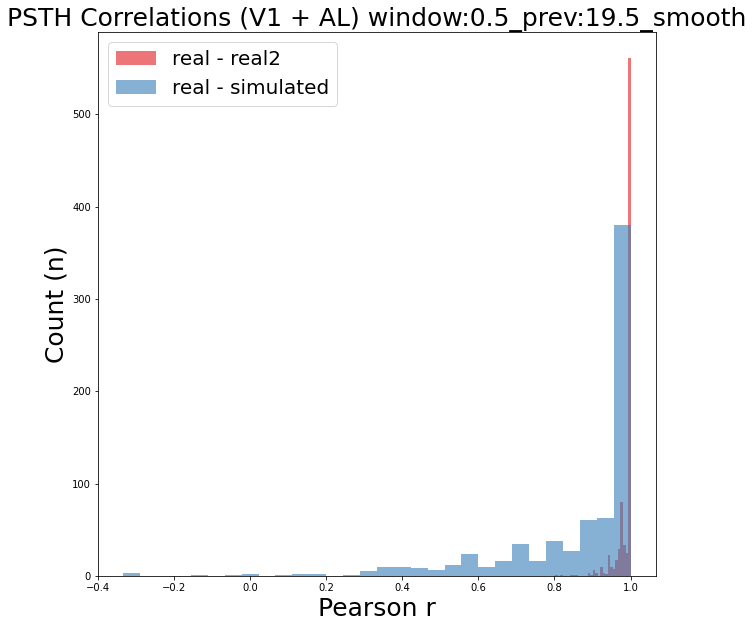

824


<Figure size 432x288 with 0 Axes>

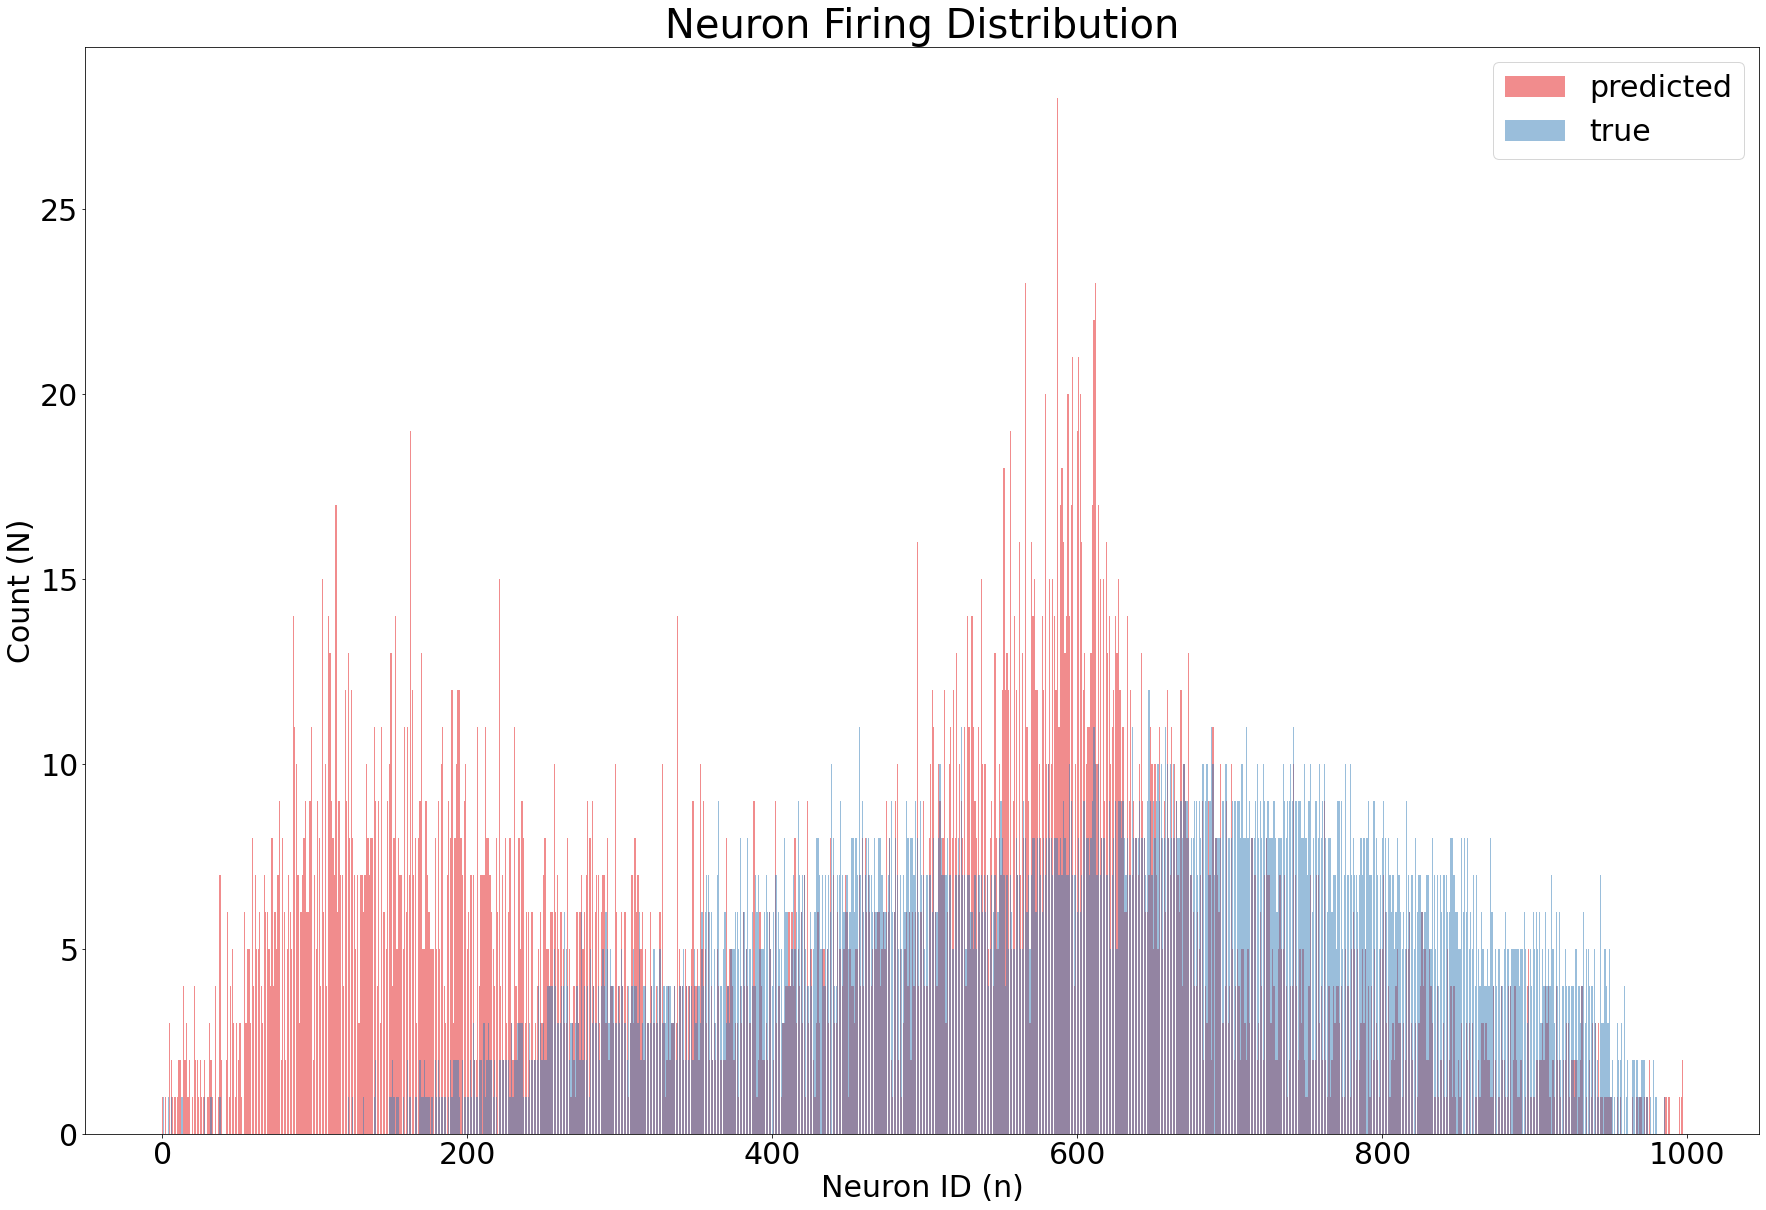

model: window:0.5_prev:19.5_smooth


In [19]:
"""

Evaluate results

"""

from visualize import *

# df_2['Trial'] -= 2
id_pred, id_true_1, id_true_2 = len(df_pred_full['ID'].unique()), len(df_1['ID'].unique()), len(df_2['ID'].unique())
print(f"id_pred: {id_pred}, id_true_1: {id_true_1}, id_true_2: {id_true_2}")

len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_2)

scores = compute_scores(df_1, df_2)
pred_scores = compute_scores(df_1, df_pred_full)
print(f"real: {scores}")
print(f"pred: {pred_scores}")


n_bins = 30
set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) {title}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
plt.hist(top_corr_real, label='real - real2', alpha=0.6, bins=n_bins)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6, bins=30)
plt.legend(fontsize=20)
plt.show()

dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)

top_p = 0
save_title = title + f'_top_p{top_p}'
plt.savefig(os.path.join(dir_name, F'psth_corr_{save_title}_.svg'))
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{save_title}_.csv'))

plot_distribution(df_1, df_pred, save_path=os.path.join(dir_name, F'psth_dist_.svg'))

total_scores = dict()
total_scores['real'] = scores
total_scores['pred'] = pred_scores

print(f"model: {title}")


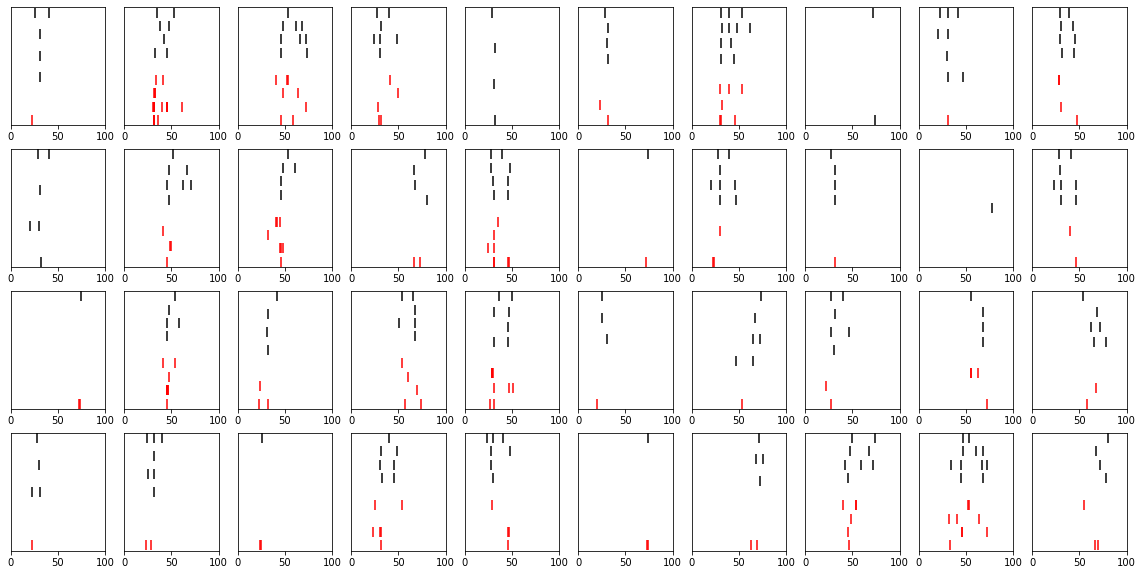

In [20]:
from visualize import plot_psth

n_ids = 40
ids = np.random.choice(df_1['ID'].unique(), n_ids)

nrows = 4
ncols = n_ids // nrows
xlims = df_pred_full['Interval'].min(), df_pred_full['Interval'].max()

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10), facecolor='white')
for i, id in enumerate(ids):
    ax = axs[i // ncols, i % ncols]
    df_true_id = df_1[df_1['ID'] == id]
    df_pred_id = df_pred_full[df_pred_full['ID'] == id]
    plot_psth(df_true_id, df_pred_id, ax=ax, xlims=(0, 100))


In [21]:
len(df_pred_full['ID'].unique())
len(df_1['ID'].unique())

len(df_pred_full['Trial'].unique())
len(df_1['Trial'].unique())


4

In [22]:
from SpikeVidUtils import SpikeTimeVidData2

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='LRN')

loader = DataLoader(train_dataset, batch_size=5, shuffle=False, pin_memory=False)
iterable = iter(train_dataset)


Length: 705418 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150


In [23]:
t = df.drop_duplicates(subset=['Interval', 'Trial'])[['Interval', 'Trial']]

In [24]:
min_interval = window + window_prev
min_trial = t['Trial'].min()

# for min_interval, keep only intervals greater than min_interval
t[t['Trial'] == min_trial] = t[t['Trial'] == min_trial][t[t['Trial'] == min_trial]['Interval'] >= min_interval]
t = t.dropna().reset_index(drop=True)

In [25]:
while int(x['trial']) == min_trial:
    x, y = next(iterable)

x, y = next(iterable)

T = len(x['id'])
P = x['pad'] - 1
T_prev = len(x['id_prev'])
P_prev = x['pad_prev'] - 4

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(f"trial: {x['trial']}")
print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")

print(f"xid_prev: {xid_prev}")

tdiff = 0.1
t_var = 'Time' # 'Interval'
int_var = 'cid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] > float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

# t_var = 'Time' # 'Interval'
# int_var = 'pid'
# df[(df[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df[t_var] <= round(float(x[int_var][1]), 2)) & (df['Trial'] == int(x['trial']))]

ValueError: only one element tensors can be converted to Python scalars

: 

In [ ]:
loader = DataLoader(train_dataset, batch_size=5, shuffle=False, pin_memory=False)
iterable = iter(loader)

In [ ]:
x, y = next(iterable)

In [ ]:
model.cpu()
preds, features, loss = model(x, y)